# Predicting Price Direction (Up/Down)

## Farming the Classification Problem

### Load Data

In [1]:
import pandas as pd

TICKER = "V"
# load data
df = pd.read_csv("../data/stock_features.csv")
df = df[df["symbol"] == TICKER]
df = df.dropna().reset_index(drop=True)

df.head(5)

,symbol,date,open,high,low,close,volume,daily_return,ma_5,volatility_10,volume_spike,day_of_week,lag_close_1,hl_range,next_day_close,price_up
0,V,2021-01-15,201.54,203.26,200.43,201.59,8755049.0,0.000248,206.910,5.488712,0.972412,4,201.86,0.014120,201.66,1
1,V,2021-01-19,203.05,204.17,200.07,201.66,9772034.0,-0.006846,204.664,5.603219,1.030051,1,201.59,0.020493,206.01,1
2,V,2021-01-20,203.03,207.19,202.23,206.01,12675730.0,0.014678,204.094,5.357649,1.248132,2,201.66,0.024527,205.14,0
3,V,2021-01-21,206.05,207.17,204.75,205.14,6517948.0,-0.004416,203.252,5.225082,0.643961,3,206.01,0.011819,202.02,0
4,V,2021-01-22,203.99,205.33,201.80,202.02,7316201.0,-0.009657,203.284,5.009405,0.812244,4,205.14,0.017493,200.98,0


### Prepare data for modelling
#### Should we include symbol as a feature?
Including the ticker as a feature helps the model differentiate between stocks, which is important when training a single model across multiple assets. While training separate models can better capture ticker-specific behavior, it’s less scalable and data-efficient. The hybrid approach—using one model with ticker as a feature—offers a practical trade-off between specialization and generalization. A feature importance analysis at the end revealed that the symbol does not make much of a difference. Hence, I chose to exclude it.


In [15]:
from sklearn.model_selection import train_test_split

feature_columns = [
    "daily_return", "ma_5", "volatility_10", "volume_spike",
    "day_of_week", "lag_close_1", "hl_range"
]

X = df[feature_columns]
y = df["price_up"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=3256)

### Model Selection
I've implemented three different models for comparision:
1. Logistic Regression (simple baseline model)
2. Random Forest (good at handling non-linearities)
3. Gradient Boosting (often achieves state-of-the-art performance)

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), feature_columns),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ["symbol"])
])

pipelines = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        # ("preprocessor", preprocessor),
        ("model", LogisticRegression(max_iter=1000, random_state=3256))
    ]),
    "Random Forest": Pipeline([
        # ("preprocessor", preprocessor),
        ("scaler", StandardScaler()),
        ("model", RandomForestClassifier(n_estimators=100, random_state=3256))
    ]),
    "Gradient Boosting": Pipeline([
        # ("preprocessor", preprocessor),
        ("scaler", StandardScaler()),
        ("model", GradientBoostingClassifier(n_estimators=100, random_state=3256))
    ])
}

In [17]:
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

results = dict()
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary"
    )

    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

# Find the best model
best_model_name = max(results, key=lambda x: results[x]['f1'])
best_model = pipelines[best_model_name]

print(f"\nBest model based on F1 score: {best_model_name}")


Logistic Regression Results:
Accuracy: 0.5519
              precision    recall  f1-score   support

           0       0.50      0.17      0.25        95
           1       0.56      0.86      0.68       117

    accuracy                           0.55       212
   macro avg       0.53      0.52      0.47       212
weighted avg       0.53      0.55      0.49       212


Random Forest Results:
Accuracy: 0.4811
              precision    recall  f1-score   support

           0       0.41      0.36      0.38        95
           1       0.53      0.58      0.55       117

    accuracy                           0.48       212
   macro avg       0.47      0.47      0.47       212
weighted avg       0.47      0.48      0.48       212


Gradient Boosting Results:
Accuracy: 0.5000
              precision    recall  f1-score   support

           0       0.43      0.34      0.38        95
           1       0.54      0.63      0.58       117

    accuracy                           0.50      

In [18]:
import joblib

joblib.dump(best_model, f"../data/model.pkl")


['../data/model.pkl']

## Feature Imporatance 
Seems like the symbol does not make much of a difference to our models

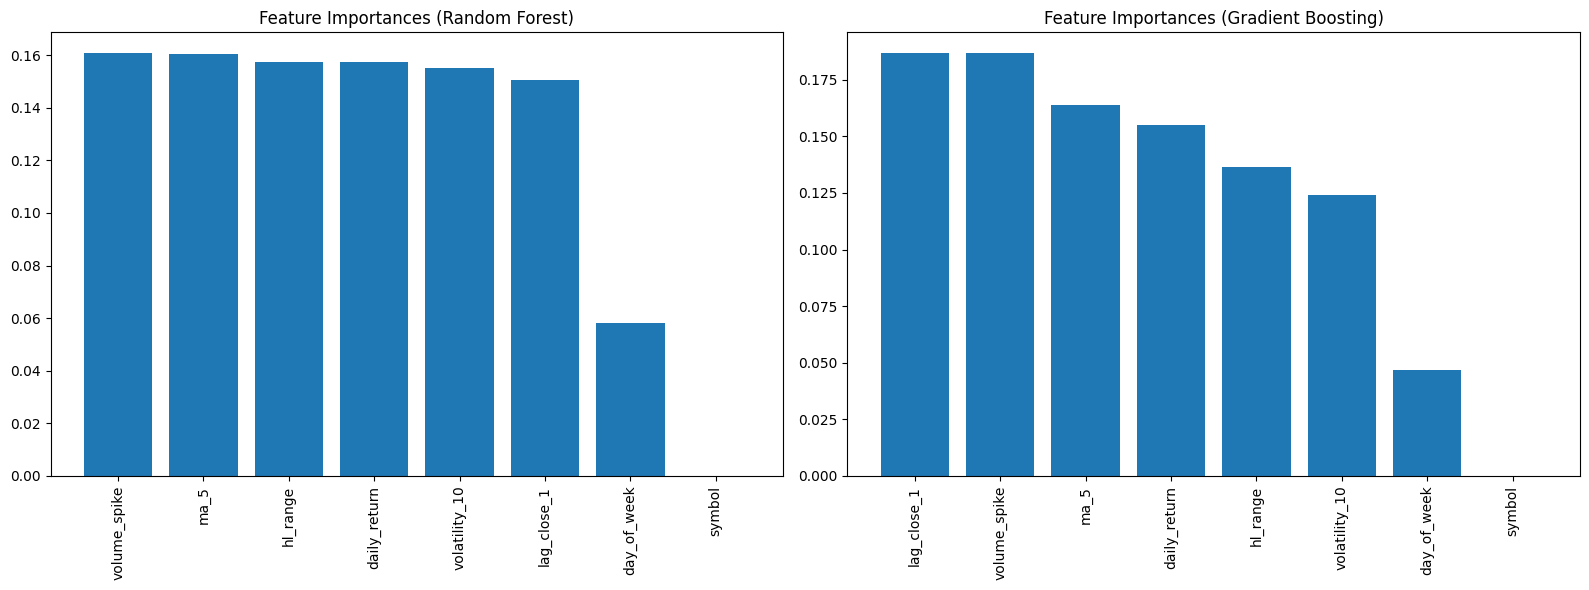

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(16, 6)) 

for ax, model_name in zip(axes, ["Random Forest", "Gradient Boosting"]):
    importances = pipelines[model_name].named_steps["model"].feature_importances_
    indices = np.argsort(importances)[::-1]
    
    ax.set_title(f"Feature Importances ({model_name})")
    ax.bar(range(X.shape[1]), importances[indices], align="center")
    ax.set_xticks(range(X.shape[1]), [(feature_columns + ["symbol"])[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()